<a href="https://colab.research.google.com/github/maanugowda/final-project-Elevate-labs/blob/main/Copy_of_E_commerce_Return_Rate_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating synthetic e-commerce data...
Synthetic dataset generated with 5000 records.

DataFrame Head:
   OrderID  CustomerID  OrderDate ProductCategory Region MarketingChannel  \
0        1        4174 2023-07-07     Electronics   East           Search   
1        2        4507 2023-11-18      Home Goods  South            Email   
2        3        1860 2023-01-13     Electronics   East           Direct   
3        4        2294 2023-07-03         Apparel   West     Social Media   
4        5        2130 2023-04-21      Home Goods   West            Email   

    Sales   Supplier  IsReturned ReturnReason  
0  437.61  SupplierD           0         None  
1  243.65  SupplierD           0         None  
2  339.86  SupplierA           0         None  
3  342.19  SupplierB           0         None  
4  113.35  SupplierC           0         None  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


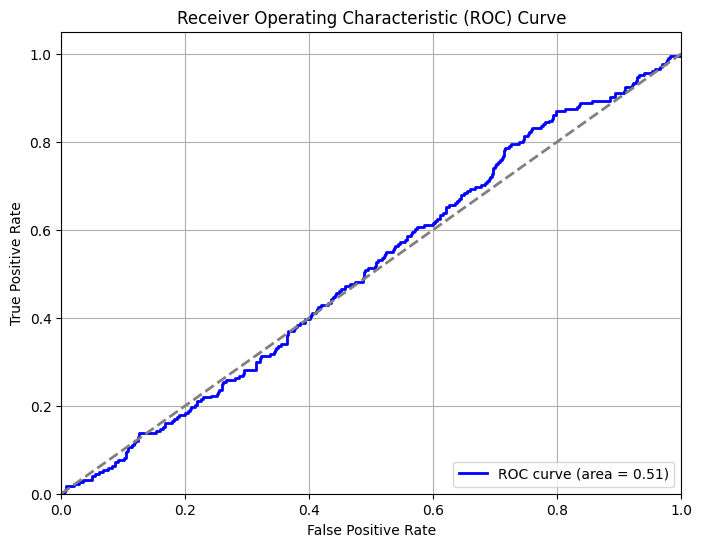


Predicting return probabilities for all orders...
Return probabilities calculated.

Identified 500 high-risk products (top 10% by probability).

High-Risk Products Sample:
      OrderID ProductCategory Region   Sales  ReturnProbability  IsReturned  \
1280     1281         Apparel  South   65.20           0.228749           0   
4155     4156         Apparel  South  100.65           0.225526           0   
358       359         Apparel   West  164.21           0.224730           0   
26         27         Apparel  South   55.35           0.222769           0   
3684     3685         Apparel   West   23.45           0.221650           0   
329       330         Apparel   West   29.33           0.221125           0   
150       151      Home Goods   West   25.15           0.220851           0   
1984     1985         Apparel   West  207.78           0.220823           0   
3279     3280         Apparel   West   53.09           0.219013           0   
2436     2437         Apparel   West 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. Generate Synthetic Dataset ---
# This section creates a sample dataset for demonstration purposes.
# In a real scenario, you would load your actual 'return and order dataset'.

print("Generating synthetic e-commerce data...")

np.random.seed(42) # for reproducibility

num_records = 5000

# Generate Order Data
data = {
    'OrderID': range(1, num_records + 1),
    'CustomerID': np.random.randint(1000, 5000, num_records),
    'OrderDate': pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 365, num_records), unit='D'),
    'ProductCategory': np.random.choice(['Electronics', 'Apparel', 'Home Goods', 'Books', 'Groceries'], num_records, p=[0.3, 0.3, 0.2, 0.1, 0.1]),
    'Region': np.random.choice(['North', 'South', 'East', 'West'], num_records, p=[0.25, 0.25, 0.25, 0.25]),
    'MarketingChannel': np.random.choice(['Social Media', 'Email', 'Search', 'Direct'], num_records, p=[0.4, 0.3, 0.2, 0.1]),
    'Sales': np.round(np.random.uniform(20, 500, num_records), 2),
    'Supplier': np.random.choice(['SupplierA', 'SupplierB', 'SupplierC', 'SupplierD'], num_records, p=[0.3, 0.25, 0.25, 0.2]),
    'IsReturned': np.random.choice([0, 1], num_records, p=[0.85, 0.15]) # 15% return rate overall
}

df = pd.DataFrame(data)

# Simulate Return Reasons for returned items
return_reasons = np.random.choice(['Wrong Size', 'Damaged', 'Not as Described', 'Changed Mind', 'Late Delivery'], num_records)
df['ReturnReason'] = np.where(df['IsReturned'] == 1, return_reasons, None)

print(f"Synthetic dataset generated with {num_records} records.")
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
print(df.info())

# --- 2. Data Cleaning and Feature Engineering ---

# Convert 'OrderDate' to datetime (already done during generation, but good practice)
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Extract Month and Year for potential analysis/features
df['OrderMonth'] = df['OrderDate'].dt.month
df['OrderYear'] = df['OrderDate'].dt.year

# --- 3. Analyze Return Rates ---

print("\n--- Return Rate Analysis ---")

# Overall Return Rate
overall_return_rate = df['IsReturned'].mean() * 100
print(f"Overall Return Rate: {overall_return_rate:.2f}%")

# Return % per Category
return_by_category = df.groupby('ProductCategory')['IsReturned'].mean().reset_index()
return_by_category['ReturnRate'] = return_by_category['IsReturned'] * 100
return_by_category = return_by_category.sort_values(by='ReturnRate', ascending=False)
print("\nReturn Rate by Product Category:")
print(return_by_category)

# Return % per Region
return_by_region = df.groupby('Region')['IsReturned'].mean().reset_index()
return_by_region['ReturnRate'] = return_by_region['IsReturned'] * 100
return_by_region = return_by_region.sort_values(by='ReturnRate', ascending=False)
print("\nReturn Rate by Region:")
print(return_by_region)

# Return % per Marketing Channel
return_by_channel = df.groupby('MarketingChannel')['IsReturned'].mean().reset_index()
return_by_channel['ReturnRate'] = return_by_channel['IsReturned'] * 100
return_by_channel = return_by_channel.sort_values(by='ReturnRate', ascending=False)
print("\nReturn Rate by Marketing Channel:")
print(return_by_channel)

# Return % per Supplier
return_by_supplier = df.groupby('Supplier')['IsReturned'].mean().reset_index()
return_by_supplier['ReturnRate'] = return_by_supplier['IsReturned'] * 100
return_by_supplier = return_by_supplier.sort_values(by='ReturnRate', ascending=False)
print("\nReturn Rate by Supplier:")
print(return_by_supplier)

# --- 4. Prepare Data for Logistic Regression ---

# Select features for the model
# We'll use categorical features and numerical 'Sales'
features = ['ProductCategory', 'Region', 'MarketingChannel', 'Supplier', 'Sales']
target = 'IsReturned'

X = df[features]
y = df[target]

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ProductCategory', 'Region', 'MarketingChannel', 'Supplier'], drop_first=True)
print("\nFeatures after One-Hot Encoding:")
print(X.head())
print(f"Shape of features (X): {X.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"\nTraining data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

# --- 5. Build and Train Logistic Regression Model ---

print("\nTraining Logistic Regression Model...")
model = LogisticRegression(solver='liblinear', random_state=42) # 'liblinear' is good for small datasets and handles L1/L2 penalties
model.fit(X_train, y_train)
print("Model training complete.")

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of being returned (class 1)

print("\n--- Model Evaluation ---")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")

# Plot ROC curve (optional, for visualization of model performance)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 6. Predict Probability of Return for all orders ---

print("\nPredicting return probabilities for all orders...")
# Ensure all columns used for prediction are present and in the same order as during training
# This is crucial for consistent predictions.
X_all = pd.get_dummies(df[features], columns=['ProductCategory', 'Region', 'MarketingChannel', 'Supplier'], drop_first=True)

# Align columns - very important if some categories might be missing in X_all vs X_train
missing_cols = set(X_train.columns) - set(X_all.columns)
for c in missing_cols:
    X_all[c] = 0
X_all = X_all[X_train.columns] # Ensure order of columns is the same

df['ReturnProbability'] = model.predict_proba(X_all)[:, 1]
print("Return probabilities calculated.")

# --- 7. Identify High-Risk Products/Orders ---

# Define a threshold for high-risk (e.g., top 10% of probabilities, or a fixed probability > 0.2)
# For demonstration, let's take the top 10% highest probability orders
num_high_risk = int(num_records * 0.10) # Top 10%
high_risk_products = df.sort_values(by='ReturnProbability', ascending=False).head(num_high_risk)

print(f"\nIdentified {len(high_risk_products)} high-risk products (top 10% by probability).")
print("\nHigh-Risk Products Sample:")
print(high_risk_products[['OrderID', 'ProductCategory', 'Region', 'Sales', 'ReturnProbability', 'IsReturned', 'ReturnReason']].head(10))

# --- 8. Generate CSV of High-Risk Products ---

output_csv_path = 'high_risk_products.csv'
high_risk_products[['OrderID', 'CustomerID', 'OrderDate', 'ProductCategory', 'Region', 'MarketingChannel', 'Sales', 'Supplier', 'ReturnProbability', 'IsReturned', 'ReturnReason']].to_csv(output_csv_path, index=False)
print(f"\nHigh-risk products saved to: {output_csv_path}")

print("\n--- Python script execution complete. ---")
print("You now have 'high_risk_products.csv' for further analysis and dashboarding.")

In [ ]:
# Save the full synthetic dataset to a CSV file for Power BI
df.to_csv('synthetic_ecommerce_data.csv', index=False)
print("\nFull synthetic dataset saved to: synthetic_ecommerce_data.csv")


Full synthetic dataset saved to: synthetic_ecommerce_data.csv


In [ ]:
# ... (rest of imports and setup) ...

# --- 1. Generate Synthetic Dataset ---
print("Generating synthetic e-commerce data...")

# ... (data generation code) ...

df = pd.DataFrame(data)

# Save the full synthetic dataset to a CSV file for Power BI
output_full_data_csv_path = 'synthetic_ecommerce_data.csv'
df.to_csv(output_full_data_csv_path, index=False)
print(f"\nFull synthetic dataset saved to: {output_full_data_csv_path}")

# ... (rest of your script for analysis and high-risk products) ...

Generating synthetic e-commerce data...

Full synthetic dataset saved to: synthetic_ecommerce_data.csv
